In [81]:
import os
import PyPDF2
import fitz
import pandas as pd
import collections
import re

In [82]:
from nltk import tokenize
# import nltk
# nltk.download('punkt')

In [83]:
dir = 'annoted_sustainability_reports/Consumer_Staples/'

In [84]:
x_label = ["Mondelez_Intl", "Hershey", "Philip_Morris_Intl", "PepsiCo", "Altria_Environmental", "PandG", "Altria_TCFD",
     "Costco", "CocaCola", "Altria_2021", "Walmart", "EsteeLauder"]

### Extracting Sentences: Refined Version

In [85]:
# this method will return a list of highlighted sentences in each page 
def get_page_highlights_coord(annot):
    page_highlights_coord = []
    while annot:
        if annot.type[0] == 8:
            all_coordinates = annot.vertices
            try:
                if len(all_coordinates) == 4:
                    highlight_coord = fitz.Quad(all_coordinates).rect
                    page_highlights_coord.append(highlight_coord)
                else:
                    all_coordinates = [all_coordinates[x:x+4] for x in range(0, len(all_coordinates), 4)]
                    for i in range(0,len(all_coordinates)):
                        coord = fitz.Quad(all_coordinates[i]).rect
                        page_highlights_coord.append(coord)
            except:
                print("NoneType found")
        annot = annot.next
    return page_highlights_coord
        

In [86]:
def get_page_highlights_text(page_highlights_coord, all_words, test_pos, repeat_coord):
    page_highlights = collections.defaultdict(list)
    for h in page_highlights_coord:
        test_dict = collections.defaultdict(list) # intialize a dictionary that keeps order and 
        # indication of where the sentence breaks occur
        for w in all_words:
            if (fitz.Rect(w[0:4]).intersects(h)): 
            # find intersections where the original report overlaps with the highlighted sentences
                new_pos = int(str("%02d" % w[5]) + str("%02d" % w[6]) + str("%02d" % w[7])) 
#                 print(new_pos, w[4])
                if new_pos not in repeat_coord:
                    repeat_coord.append(new_pos)
                    if test_pos <  new_pos:
#                         print('less than', test_pos, new_pos, w[4])
                        test_pos = new_pos 
                        test_dict[new_pos].append(w[4])
                        page_highlights[new_pos].append(test_dict[new_pos][0])
#                         page_highlights.append({new_pos : test_dict[new_pos]})
                    else:
#                         print('greater than', test_pos, new_pos, w[4])
                        test_dict = collections.defaultdict(list)
                        test_pos = 0
                        test_dict[new_pos].append(w[4])
                        page_highlights[new_pos].append(test_dict[new_pos][0])
#                         page_highlights.append({new_pos : test_dict[new_pos]})
                else:
                    continue
    return page_highlights
                    

In [87]:
def get_total_highlights_text(total_page_highlights):
    total_page_highlights_text = []
    for i in total_page_highlights:
        highlights = ""
        sorted_dict = sorted(i.items(), key = lambda kv:kv[0], reverse = False)
        for k in sorted_dict:
            highlights += k[1][0] + " "
            
        total_page_highlights_text.append(highlights)
    
    return total_page_highlights_text

In [88]:
def make_text(words):
    """Return textstring output of getText("words").

    Word items are sorted for reading sequence left to right,
    top to bottom.
    """
    line_dict = {}  # key: vertical coordinate, value: list of words
    words.sort(key=lambda w: w[0])  # sort by horizontal coordinate
    for w in words:  # fill the line dictionary
        y1 = round(w[3], 0)  # bottom of a word: don't be too picky!
        word = w[4]  # the text of the word
        line = line_dict.get(y1, [])  # read current line content
        line.append(word)  # append new word
        line_dict[y1] = line  # write back to dict
    lines = list(line_dict.items())
    lines.sort()  # sort vertically
    return "\n".join([" ".join(line[1]) for line in lines])

In [89]:
# final list of relevant sentences
final_relevant = []   
final_relevant_comp = []

# final list of all sentences 
final_all = []
final_all_comp = []

# running all the files in the industry folder
for file in os.listdir(dir): 
    
    # f = filename + directory
    f = os.path.join(dir, file) 
    print(f)
    
    # comp_lab = to label sentence by companies
    comp_lab = list(filter(lambda x:  x in f, x_label))
    print(comp_lab)
    
    # opening each company report
    doc = fitz.open(f) 
    print(doc)
    
    # store the entire report in this list
    all_result = []
    
    test_pos = 0 # keep track of whether values of coordinates increase or decrease --> 
    #reinitialize if decreases because that means its a new set of sentences (paragraph)
    
    total_page_highlights = [] # use this list to store all the highlighted sentences of each page
    
#     test_final_relevant = [] # use this to test printing relevant sentences by company 

    # iterate each page of the document
    for page in doc:
        
        # extract all the sentences in pdf --> store it in all_result
        all_text = page.get_text_words()
        all_text = [i[4] for i in all_text]
        all_result.append(" ".join(all_text))
        
        # extract highlighted sentences coordinates from pdf --> using the get_page_highlights_coord method
        annot = page.first_annot
        page_highlights_coord = get_page_highlights_coord(annot)
        
        # convert the page into text so that it can be compared with highlighted coordinates
        all_words = page.get_text_words()
#         print(all_words)
        
        # only iterate if highlights were detected
        if len(page_highlights_coord) > 0:
            repeat_coord = []
            # use the get_page_highlights_text to extract coordinates and words into dictionary 
            #(remove duplicated coordinates here as well)
            page_highlights = get_page_highlights_text(page_highlights_coord, all_words, test_pos, repeat_coord)
            total_page_highlights.append(page_highlights)
            
    # use get_total_highlights_text method to sort words by coordinates 
    # [so that we can get a cleaner version of sentences] and extract the final version of relevant sentences        
    total_highlights = get_total_highlights_text(total_page_highlights)
    
    # loop around total_highlights to tokenize sentences (breaking chunks into sentences)
    for i in total_highlights:
        i = re.sub("\xa0", " ", i)
        i = re.sub("\t", " ", i)
        i = re.sub("\r", " ", i)
        i = re.sub("\n", " ", i)
        i = re.sub(" +", " ", i)
#         i = i.strip()
        final_relevant += tokenize.sent_tokenize(i)
        final_relevant_comp += comp_lab * len(tokenize.sent_tokenize(i))
    
#     print('>>>>RELEVANT<<<<')
#     print(final_relevant)
#         test_final_relevant += tokenize.sent_tokenize(i.replace("\n", " "))

    # loop around all_result to tokenize sentences as well
    for i in all_result:
        i = re.sub("\xa0", " ", i)
        i = re.sub("\t", " ", i)
        i = re.sub("\r", " ", i)
        i = re.sub("\n", " ", i)
        i = re.sub(" +", " ", i)
#         i = i.strip()
        final_all += tokenize.sent_tokenize(i)
        final_all_comp += comp_lab * len(tokenize.sent_tokenize(i))
        
#     print('>>>>ALL<<<<')
#     print(final_all)

            


annoted_sustainability_reports/Consumer_Staples/Mondelez_Intl_2021_Snacking_Made_Right_ESG_Report.pdf
['Mondelez_Intl']
Document('annoted_sustainability_reports/Consumer_Staples/Mondelez_Intl_2021_Snacking_Made_Right_ESG_Report.pdf')
annoted_sustainability_reports/Consumer_Staples/Hershey_2021_esg_report.pdf
['Hershey']
Document('annoted_sustainability_reports/Consumer_Staples/Hershey_2021_esg_report.pdf')
annoted_sustainability_reports/Consumer_Staples/Philip_Morris_Intl_2021_integrated_report.pdf
['Philip_Morris_Intl']
Document('annoted_sustainability_reports/Consumer_Staples/Philip_Morris_Intl_2021_integrated_report.pdf')
annoted_sustainability_reports/Consumer_Staples/PepsiCo_2021_ESG_report.pdf
['PepsiCo']
Document('annoted_sustainability_reports/Consumer_Staples/PepsiCo_2021_ESG_report.pdf')
annoted_sustainability_reports/Consumer_Staples/Altria_Environmental_Data.pdf
['Altria_Environmental']
Document('annoted_sustainability_reports/Consumer_Staples/Altria_Environmental_Data.pdf'

### Relevant & All Sentences into a DataFrame

In [90]:
rel_text_df = pd.DataFrame([final_relevant, final_relevant_comp]).transpose().rename(columns = {0: 'relevant_sentences', 1: 'company_label'})
rel_text_df.head()

,relevant_sentences,company_label
0,"By 2025, reduce end-to-end CO2e emissions by 1...",Mondelez_Intl
1,Climate Action For the past few years we have ...,Mondelez_Intl
2,"zero, which is subject to verification by the ...",Mondelez_Intl
3,"In the meantime, we continue to deliver agains...",Mondelez_Intl
4,"In 2021, we reduced our Scope 1 and 2 (market-...",Mondelez_Intl


In [91]:
all_text_df = pd.DataFrame([final_all, final_all_comp]).transpose().rename(columns = {0: 'all_sentences', 1: 'company_label'})
all_text_df.head()

,all_sentences,company_label
0,2021 ESG Report Snacking Made Right,Mondelez_Intl
1,Governance Sustainable Snacking Colleague & Co...,Mondelez_Intl
2,We provide many of the world’s favorite snack ...,Mondelez_Intl
3,"This is what motivates us, day-in-day-out, all...",Mondelez_Intl
4,Whether it’s taking a bite out of your favorit...,Mondelez_Intl


In [92]:
for i in all_text_df.all_sentences:
    print(i)
    print()

2021 ESG Report Snacking Made Right

Governance Sustainable Snacking Colleague & Community Well-being Snacking Mindfully Strategy & Performance 2 MONDELĒZ INTERNATIONAL SNACKING MADE RIGHT 2021 ESG REPORT Empowering people to snack right From Cadbury Dairy Milk chocolate to Triscuit crackers, 7 Days croissants, Oreo cookies and more – at Mondelēz International, we’re here to empower people to snack right.

We provide many of the world’s favorite snack foods, such as, chocolate, biscuits and other baked snacks, that we strive to make the right way.

This is what motivates us, day-in-day-out, all around the world.

Whether it’s taking a bite out of your favorite chocolate bar, dunking a biscuit in your breaktime coffee, tucking into a pastry on-the- go, or enjoying a healthy savory cracker at the end of the day – one delicious snack can make a moment more meaningful.

And when the right snacks, for the right moments, are made the right way, time and time again, we believe they can be eve

### Relevant Sentences Statistics

In [93]:
rel_text_df.groupby('company_label', sort = False).count()

,relevant_sentences
company_label,
Mondelez_Intl,22
Hershey,14
Philip_Morris_Intl,11
PepsiCo,8
PandG,12
CocaCola,8
Altria_2021,1
Walmart,3
EsteeLauder,15


In [94]:
rel_text_df[rel_text_df.duplicated()]

,relevant_sentences,company_label


In [95]:
all_text_df.groupby('company_label', sort = False).count()

,all_sentences
company_label,
Mondelez_Intl,1505
Hershey,1348
Philip_Morris_Intl,3826
PepsiCo,246
Altria_Environmental,27
PandG,837
Altria_TCFD,348
Costco,129
CocaCola,1304


### Getting Sentence Statistics 

In [96]:
# count rel sentences 
rel_count = rel_text_df.groupby('company_label', sort = False).count()

# count all sentences
sent_count = all_text_df.groupby('company_label', sort = False).count()

In [97]:
sentences_list = []
rel_sent_list = []

final_text_stat = pd.concat([sent_count, rel_count],  sort = False, axis = 1)

[rel_sent_list.append(rel_sent) for rel_sent in final_text_stat['relevant_sentences']]    
[sentences_list.append(all_sent) for all_sent in final_text_stat['all_sentences']]    
    
final_text_stat['relevant_sentences'] = final_text_stat['relevant_sentences'].fillna(0)
final_text_stat['percentages'] = final_text_stat['relevant_sentences'] / final_text_stat['all_sentences'] * 100
final_text_stat

,all_sentences,relevant_sentences,percentages
company_label,,,
Mondelez_Intl,1505,22.0,1.461794
Hershey,1348,14.0,1.038576
Philip_Morris_Intl,3826,11.0,0.287507
PepsiCo,246,8.0,3.252033
Altria_Environmental,27,0.0,0.000000
PandG,837,12.0,1.433692
Altria_TCFD,348,0.0,0.000000
Costco,129,0.0,0.000000
CocaCola,1304,8.0,0.613497


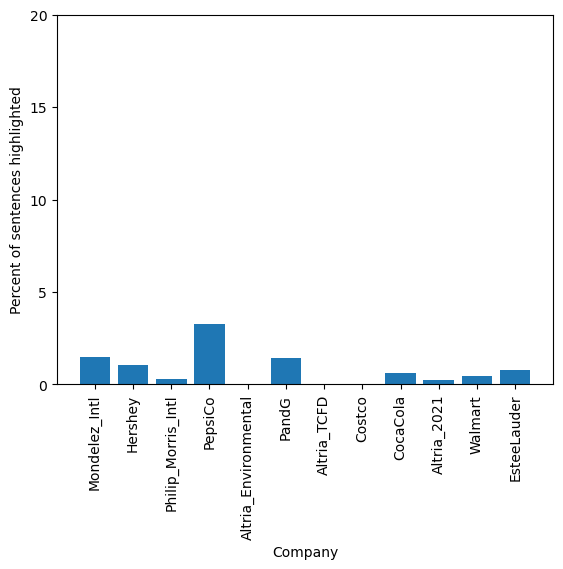

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import glob
y = []

i = 0

for file in os.listdir(dir):
    y.append(100 * (rel_sent_list[i])/sentences_list[i])
    i = i+1

plt.bar(x_label, y, width = 0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Company")
plt.ylabel("Percent of sentences highlighted")
plt.yticks(np.arange(0, 25, 5))
plt.show()

In [99]:
import pandas as pd

series = pd.Series(y)
series.describe()

count    9.000000
mean     1.064798
std      0.936352
min      0.240385
25%      0.445765
50%      0.809935
75%      1.433692
max      3.252033
dtype: float64

### Exporting and Saving Files 

In [100]:
#storing variable so they can be called between notebooks (for ML and aggregate work later on)

CONSTA_reltext = rel_text_df
CONSTA_alltext = all_text_df
CONSTA_stat = final_text_stat

%store CONSTA_reltext
%store CONSTA_alltext
%store CONSTA_stat

Stored 'CONSTA_reltext' (DataFrame)
Stored 'CONSTA_alltext' (DataFrame)
Stored 'CONSTA_stat' (DataFrame)
